In [17]:
import numpy as np
import matplotlib.pyplot as plt

### 导入OrderedDict类：
from collections import OrderedDict

### 导入struct库，用于解包二进制数据：
import struct

### 导入os库，用于从云上读取数据：
import os

### 先进行数据预处理，包括读取、格式转换；归一化（图像数据）/编码方式转换（标签数据）：

In [ ]:
### 看一下当前路径；必要的话切到'/root/.jupyter/lab/workspaces/work'：
os.getcwd()
#os.chdir("/root/.jupyter/lab/workspaces/work")

In [25]:
### 设定待读取的文件名列表，逐个读取：
dir_datasets = os.getcwd()
list_filenames = ['train-images-idx3-ubyte','t10k-images-idx3-ubyte',
                  'train-labels-idx1-ubyte','t10k-labels-idx1-ubyte']

In [22]:
### 读取训练集图像数据：
path_training_imgs = dir_datasets+'/'+list_filenames[0]
with open(path_training_imgs, "rb") as file_data_training:
    data_training = file_data_training.read() ### 读出全部的数据
    '''该数据的第0-15位分别是训练集的magic number, 图片数和行列像素数，各占4位。跳过。'''
    pics_training = data_training[16:] ### 以下为训练集图片数据
    length_pics_training = len(pics_training)
    #print(length_pics_training) ### 训练集图片数据的长度，应为60000✕28✕28 = 47040000：
    data_pics_training = struct.unpack(">{}B".format(length_pics_training), pics_training) ### 大端法解包

In [23]:
### 将训练集图片数据转成np.array, 查看一下长度是否正确，应为47040000：
data_pics_training = np.array(data_pics_training)
#data_pics_training.shape

(47040000,)

In [24]:
### 将训练集图片数据转换成784列（即后续的size_input，第一个权重矩阵的列数）：
data_pics_training_shaped = np.reshape(data_pics_training, (60000, 784))
#data_pics_training_shaped.shape

(60000, 784)

In [26]:
### 同法读取测试集图片数据：
path_testing_imgs = dir_datasets+'/'+list_filenames[1]
with open(path_testing_imgs, "rb") as file_data_testing:
    data_testing = file_data_testing.read()
    pics_testing = data_testing[16:]
    length_pics_testing = len(pics_testing)
    #print(length_pics_testing) ### 测试集图片数据的长度，应为10000✕28✕28 = 7840000：
    data_pics_testing = struct.unpack(">{}B".format(length_pics_testing), pics_testing) ### 大端法解包

7840000


In [28]:
### 将测试集图片数据转成np.array, 长度应为7840000：
data_pics_testing = np.array(data_pics_testing)
#data_pics_testing.shape

(7840000,)

In [29]:
### 将测试集图片数据也转换成784列：
data_pics_testing_shaped = np.reshape(data_pics_testing, (10000, 784))
#data_pics_testing_shaped.shape

(10000, 784)

In [30]:
### 将训练集和测试集图片数据都归一化：
x_train = data_pics_training_shaped.astype(np.float32)/255.0
x_test = data_pics_testing_shaped.astype(np.float32)/255.0

In [31]:
### 下面打开训练集的标签数据：
path_training_labels = dir_datasets+'/'+list_filenames[2]
with open(path_training_labels, "rb") as file_labels_training:
    data_training_l = file_labels_training.read()
    '''该数据的第0-7位分别为magic number和标签数。跳过。'''
    labels_training = data_training_l[8:] ### 以下为训练集标签数据：
    length_labels_training = len(labels_training)
    print(length_labels_training) ### 训练集标签数据的长度，应为60000：
    data_labels_training = struct.unpack(">{}B".format(length_labels_training), labels_training)

60000


In [32]:
### 格式转换，长度应为60000：
data_labels_training = np.array(data_labels_training)
#data_labels_training.shape

(60000,)

In [33]:
### 同法打开测试集的标签数据：
path_testing_labels = dir_datasets+'/'+list_filenames[3]
with open(path_testing_labels, "rb") as file_labels_testing:
    data_testing_l = file_labels_testing.read()
    labels_testing = data_testing_l[8:] ### 以下为测试集标签数据：
    length_labels_testing = len(labels_testing)
    #print(length_labels_testing) ### 测试集标签数据的长度，应为10000：
    data_labels_testing = struct.unpack(">{}B".format(length_labels_testing), labels_testing)

10000


In [34]:
### 格式转换，长度应为10000：
data_labels_testing = np.array(data_labels_testing)
#data_labels_testing.shape

(10000,)

In [35]:
### 定义非独热转独热编码的函数：
def to_onehot(x): ### x为待转换的numpy数组
    label_onehot = np.zeros((len(x), len(np.unique(x)))) ### 行数是原标签的行数（原标签应为N行一列），列数是原标签惟一值的个数
    for i in range(len(x)):
        j = x[i]
        label_onehot[i][j] = 1
    return label_onehot

In [36]:
### 转换训练集标签，查看形状；应为60000*10：
t_train = to_onehot(data_labels_training)
#t_train.shape

(60000, 10)

In [37]:
### 转换测试集标签，查看形状；应为10000*10：
t_test = to_onehot(data_labels_testing)
#t_test.shape

(10000, 10)

### 数据准备完毕后，接下来就要着手构建神经网络，并通过梯度下降法求出损失函数的最小值（理想状况下）；以及与之相对应的参数（权重和偏置值）。

### 本法的大致原理如下：
### 训练集的图像数据（60000×784），在二层神经网络的第一层（1），先点乘一个权重矩阵W1（784×M），加上一个广播后的偏置数组b1（M）；
### 将这一步结果用ReLU函数激活，结果为（60000×M）的矩阵。
### 在二层神经网络的第二层（2），将上述结果点乘第二个权重W2（M×10）,再加上第二个偏置值b2（10）；结果为（60000×10）的矩阵。
### 下一步，将该矩阵通过softmax运算，求出每行中的每个值（对应数字0-9）出现的相对概率；结果仍为（60000×10）的矩阵。
### 下一步，将上一步的结果与独热化的标签数据【亦为（60000×10）的矩阵】比较，求出交叉熵结果（是个标量）。

### 该交叉熵函数分别对上述的W1,b1,W2,b2求偏导（用误差反向传播法，见后文），其集合即为梯度。
### 以上各参数值分别减去“学习率”乘以对应偏导值的积（即沿偏导方向“往下走一步”），即向交叉熵函数的最小值靠近了一步（理想状态下）。
### 然后用更新过后的各参数值再照上法处理图像数据，此处完成一个迭代循环。重复以上各步，直至交叉熵函数值趋于稳定；
### 取出对应的各参数，即可用于测试集数据的预测和相应的精度计算。

### 上述的W1,b1,W2,b2为神经网络的参数；而学习率、初始权重的标准差值（见后文）和迭代次数等称为超参数，是神经网络优化的对象。

### 下面，先定义softmax和交叉熵函数，然后建立各运算的层（类），包括W/b处理数据的层，ReLU函数的层，以及softmax/交叉熵函数层。
### 每个层中都会定义正向和反向的方法；正向用于上文中提及的各步运算，反向用于求偏导。

In [66]:
### 定义用于求每行各值概率的softmax函数：
def softmax(x): ### 这里的x是二维数组
    x = x.T
    x = x - np.max(x, axis=0) ### 防溢出
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

In [67]:
### 定义将独热和非独热编码交叉熵合二为一的函数：
def cross_entropy_error(y,t): ### 这里的y是预测结果，t是标签：
    if y.ndim == 1: ### 如果两者都是一维数组，那么要转为矩阵的形式：
        y = y.reshape(1, y.size)
        t = t.reshape(1, t.size)
    delta = 1e-7 ### 保护
    batch_size = y.shape[0] ### batch_size为 y（抽出的结果矩阵的一部分）的行数
    if y.shape == t.shape: ### 独热：
        return -np.sum(t*np.log(y+delta)) / batch_size ### 求交叉熵的均值；相当于“归一化”
    else: ### 非独热：
        return -np.sum(np.log(y[np.arange(batch_size),t]+delta)) / batch_size

### 以下为各运算的层。在后续定义神经网络（类）的时候，会用OrderedDict把各个类按运算顺序按串联起来；
### 正向运算就按正常串联顺序跑，反向时按逆序跑（反向误差传播法）。
### 实际上，反向误差传播法就是求后一步的结果对前一步的偏导；根据复合函数求偏导的法则，最终结果对W1~b2各参数的偏导，就是各步偏导的积。

In [68]:
### 定义权重和偏置运算层：
class AffineLayer:
    ### 初始化时直接给self.W和self.b属性赋值，不用在调用任何其他方法时再赋值；这么做是为了与前后的层衔接方便。
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    ### 正向方法，输入原始数据数组，返回权重/偏置值变换后的数组（形状变了）：
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b  ### 本函数（方法）内赋值的self.x，不直接调用；初始化过的self.W和self.b可以直接用
        return out

    '''
    反向方法，输入前一步反向方法得出的数组，返回与该步输入的原始数据数组形状相同的数组；
    此外，还生成并存储了损失函数对权重的梯度（其实是前一步反向方法得出的数组与该步输入的原始数据数组的转置的点乘）
    和对偏置的梯度（前一步反向方法得出的数组在列方向上的逐项加和，即列数不变，“压缩”为一行）
    '''
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)  ### 这里给self.dW和self.db两个属性赋值；调用过一次backward就有了
        self.db = np.sum(dout, axis=0)
        return dx  ### 这里只返回dx，不（直接）返回dW和db是出于与前后各层衔接方便的考量

In [69]:
### 构建ReLU函数的层：
'''ReLU函数实为第一层神经网络权重/偏置运算后的“激活”函数；
其运算为：对于该矩阵的每一个值，大于零的原样输出，小于等于零的输出零。
返回一个与输入矩阵形状相同的矩阵。'''
class ReLULayer:
    def __init__(self):
        ### 这里的mask后续要“填入”（对输入的x的各元素值判断得出）的是布尔值，即元素值是否小于等于0
        ### 因为正向时需要进行判断并存储，以便反向时可以使用，所以初始化时要设定：
        self.mask = None

    def forward(self, x):  ### 这里的x是数组：
        self.mask = (x <= 0)  ### 布尔值；判断元素值是否小于等于零
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0  ### 反向时，若元素值小于等于零，则偏导为零（偏导流“中止”）；否则偏导流原样流下去：
        dx = dout
        return dx

In [70]:
### 构建SoftMax和交叉熵合二为一的层：
class SoftMaxLossLayer:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    ### 正向：输入前一步权重/偏置值变换处理的结果数组（“准”预测结果）和标签，
    ### 先用Softmax转为概率值（“真正的”预测结果），再计算并返回该概率值与标签间的损失函数值：
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    ### 反向：输入默认值为1的损失函数对自身的偏导，输出与y和t形状相同的数组：
    def backward(self, dout=1):
        batch_size = self.t.shape[0]  ### 行数；也可以是x或y的行数，都是一样的
        dx = (self.y - self.t) / batch_size
        return dx

### 以上为各步正/反向方法的层。
### 以下定义二层神经网络。

In [71]:
### 二层神经网络的类：
class TwoLayerNet:
    def __init__(self, size_input, size_hidden, size_output, wt_init_std=0.01):
        '''权重和偏置值的初始化。
        设定权重矩阵W1, W2的值为遵循高斯分布的随机值；但要乘上一个超参数wt_init_std(标准差)。
        设定偏置值数组b1,b2为全零。
        '''
        self.params = {}
        self.params["W1"] = wt_init_std * np.random.randn(size_input, size_hidden)
        self.params["b1"] = np.zeros(size_hidden)
        self.params["W2"] = wt_init_std * np.random.randn(size_hidden, size_output)
        self.params["b2"] = np.zeros(size_output)

        '''定义layers属性为有序字典；把上文定义的各运算的层按顺序放入;
        之后按需要顺序或逆序调用即可。'''
        self.layers = OrderedDict()
        self.layers['Affine1'] = AffineLayer(self.params['W1'], self.params['b1'])
        self.layers['ReLU'] = ReLULayer()
        self.layers['Affine2'] = AffineLayer(self.params['W2'], self.params['b2'])
        self.lastlayer = SoftMaxLossLayer()

    def predict(self, x):
        '''所谓预测, 即按顺序调用上述layers中的各层。
        注意这里不包括最后一层；因为softmax和交叉熵是一起运算的。
        这里的x为输入的原始数据（的一部分，取决于batch_size）。'''
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        '''这里的x和上文predict属性的参数x一样，指的是输入数据。
        t为标签数据。
        这里的lastlayer，即先对y进行softmax运算求概率，再与t值一起求交叉熵值。'''
        y = self.predict(x)
        return self.lastlayer.forward(y, t)

    def accuracy(self, x, t):
        '''精度计算，即分别求出预测结果y和标签t每行的最大值，然后逐行对比。
        相同的就计数为1，最终除以行数，为精度值。'''
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def partial_gradient(self, x, t):
        '''根据上文所述，求最终结果（交叉熵值）对W1~b2的偏导，实则为各步偏导的积。'''
        ### 正向：直接调用loss方法
        self.loss(x, t)
        ### 反向：设最后一步对自身的偏导值为1，逆序调用各层，即可求出偏导值。
        dout = 1
        dout = self.lastlayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        '''最后，以字典的形式存储梯度值。字典的每个值即为交叉熵函数对对应键的偏导值。'''
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db

        return grads

In [90]:
'''最后，就是通过神经网络类的实例化完成最终的迭代过程。
这里的size_input和size_output是固定的；size_hidden则不一定。
我在这里没有作最优化；你有兴趣的话可以尝试。
但是，我把超参数之一的初始权重标准值改成了0.05;
因为你会发现如果用0.01的话，迭代结果损失函数值根本下不去。原因你有兴趣的话，之后解释。
建议你把这项再往上调，实现最优化。'''
network = TwoLayerNet(size_input=784, size_hidden=50, size_output=10, wt_init_std=0.05)

In [91]:
### 设定其他超参数，如迭代次数、学习率等。这些超参数可进行最优化尝试。
iters_num = 10000
learning_rate = 0.1

In [92]:
### 设定一些其他需要用于迭代过程的变量。空列表用于存储迭代结果，以及预测精度。
train_size = x_train.shape[0]
batch_size = 100
train_loss_list = []
train_acc_list = []
test_acc_list = []

### 迭代（每次随机抽取一个batch）：
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    ### 调用partial_gradient方法求梯度：
    grads = network.partial_gradient(x_batch, t_batch)

    ### 对每个参数值进行更新，即沿梯度方向“向下走一小步”：
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grads[key]

    ### 求损失函数值，存储结果：
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    ### 每跑完一个epoch(即理论上循环完一轮60000条训练集图像数据)，分别计算一次训练集和测试集的精度值：
    if (i*batch_size)%train_size == 0:
        train_acc = round(network.accuracy(x_train, t_train)*100, 2)
        test_acc = round(network.accuracy(x_test, t_test)*100, 2)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'第{(i*batch_size)//train_size}个epoch结束后，在训练集和测试集上的预测精度分别为{train_acc}%和 {test_acc}%。\n')

第0个epoch结束后，在训练集和测试集上的预测精度分别为13.29%和 13.73%。

第1个epoch结束后，在训练集和测试集上的预测精度分别为90.93%和 91.41%。

第2个epoch结束后，在训练集和测试集上的预测精度分别为92.94%和 93.14%。

第3个epoch结束后，在训练集和测试集上的预测精度分别为94.04%和 94.08%。

第4个epoch结束后，在训练集和测试集上的预测精度分别为94.64%和 94.41%。

第5个epoch结束后，在训练集和测试集上的预测精度分别为95.3%和 95.21%。

第6个epoch结束后，在训练集和测试集上的预测精度分别为95.88%和 95.51%。

第7个epoch结束后，在训练集和测试集上的预测精度分别为96.19%和 95.8%。

第8个epoch结束后，在训练集和测试集上的预测精度分别为96.54%和 96.08%。

第9个epoch结束后，在训练集和测试集上的预测精度分别为96.85%和 96.4%。

第10个epoch结束后，在训练集和测试集上的预测精度分别为97.12%和 96.53%。

第11个epoch结束后，在训练集和测试集上的预测精度分别为97.19%和 96.67%。

第12个epoch结束后，在训练集和测试集上的预测精度分别为97.35%和 96.75%。

第13个epoch结束后，在训练集和测试集上的预测精度分别为97.55%和 96.67%。

第14个epoch结束后，在训练集和测试集上的预测精度分别为97.78%和 96.94%。

第15个epoch结束后，在训练集和测试集上的预测精度分别为97.9%和 97.16%。

第16个epoch结束后，在训练集和测试集上的预测精度分别为97.97%和 97.05%。



In [86]:
### 最终结果，迭代优化后的参数在训练集和测试集上的精度：
train_acc_final = round(network.accuracy(x_train, t_train)*100, 2)
test_acc_final = round(network.accuracy(x_test, t_test)*100, 2)
print(f'迭代完成后，在训练集和测试集上的最终精度分别为{train_acc_final}%和{test_acc_final}%。\n')

迭代完成后，在训练集和测试集上的最终精度分别为99.9%和97.41%。



Text(0, 0.5, 'Values of Loss Functions')

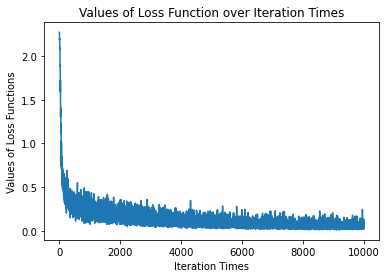

In [95]:
### 损失函数值对迭代次数作图：
times_iter = np.arange(10000)
plt.plot(times_iter,train_loss_list)
plt.title("Values of Loss Function over Iteration Times")
plt.xlabel("Iteration Times")
plt.ylabel("Values of Loss Functions")

No handles with labels found to put in legend.


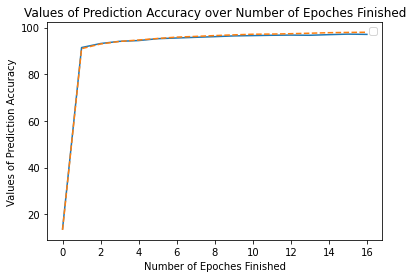

In [96]:
### 训练集和测试集精度对epoch次数作图：
num_epoch = np.arange(17)
plt.plot(num_epoch,test_acc_list)
plt.plot(num_epoch,train_acc_list, linestyle = "--")
plt.title("Values of Prediction Accuracy over Number of Epoches Finished")
plt.xlabel("Number of Epoches Finished")
plt.ylabel("Values of Prediction Accuracy")
plt.legend()
